In [2]:
import pandas as pd
import numpy as np 
raw_data = pd.read_csv("GSE145668_combined_data.csv")
data = raw_data.drop(columns=['GeneName','GeneSymbol'])
data = data.transpose()
data.columns = raw_data['GeneSymbol']
data['Label'] = np.where(data.index.str.contains('Ctrl', na=False), 'Ctrl', 'AA')
data.head()

GeneSymbol,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADAT,AAED1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,Label
Ctrl1_L1_sc01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,Ctrl
Ctrl1_L1_sc02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ctrl
Ctrl1_L1_sc03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ctrl
Ctrl1_L1_sc04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,Ctrl
Ctrl1_L1_sc05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ctrl


# MAST

/opt/anaconda3/envs/Automation_of_Scientific_Research/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T/ipykernel_57484/2791599079.py:89: RuntimeWarning: divide by zero encountered in log
  combined_stat = -2 * (np.log(p_detect) + np.log(p_cont))


Total genes analyzed: 17282
Significantly differentially expressed genes (FDR < 0.05): 9007
Up-regulated genes (FDR < 0.05, log2FC > 1): 1438
Down-regulated genes (FDR < 0.05, log2FC < -1): 166

Top up-regulated genes:
         Gene    log2FC  FDR  pct_expressed_ctrl  pct_expressed_treatment
8495   MBOAT7  3.219766  0.0            1.062387                 5.068312
7679    KLRB1  1.612355  0.0           12.183544                19.678272
12715   SAAL1  1.082278  0.0           16.659132                23.071838
12706   S100P  3.247675  0.0            0.858951                 4.142794
12703  S100A9  3.886832  0.0           10.646474                23.821067
12702  S100A8  4.776159  0.0            6.283906                18.510357
14040    SQLE  1.160435  0.0           20.953888                26.817981
3122   CLEC7A  2.095263  0.0            2.011754                 5.509035
10544   PCLAF  1.124863  0.0           33.634720                38.629352
3124   CLECL1  2.774610  0.0            1

/opt/anaconda3/envs/Automation_of_Scientific_Research/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


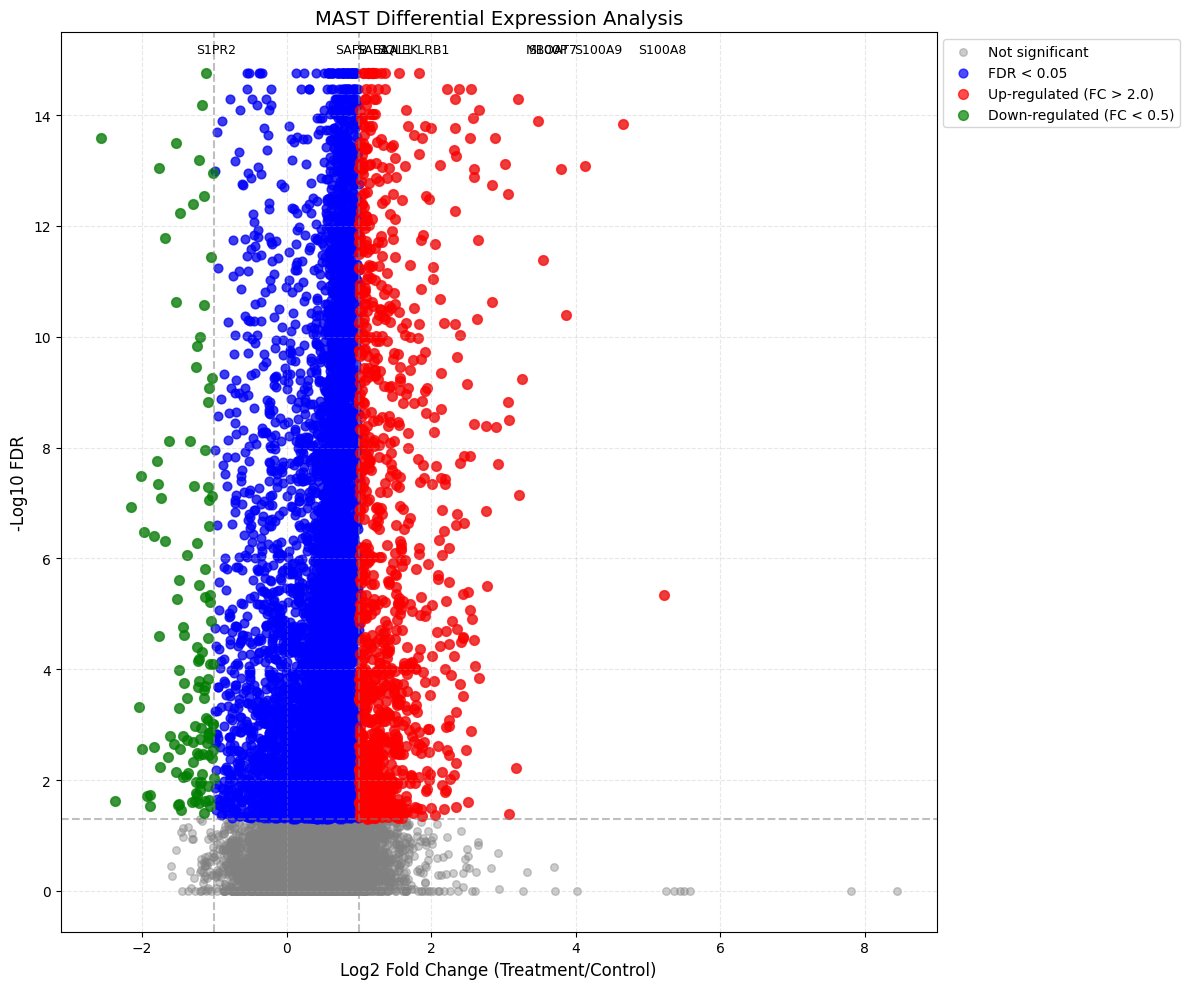

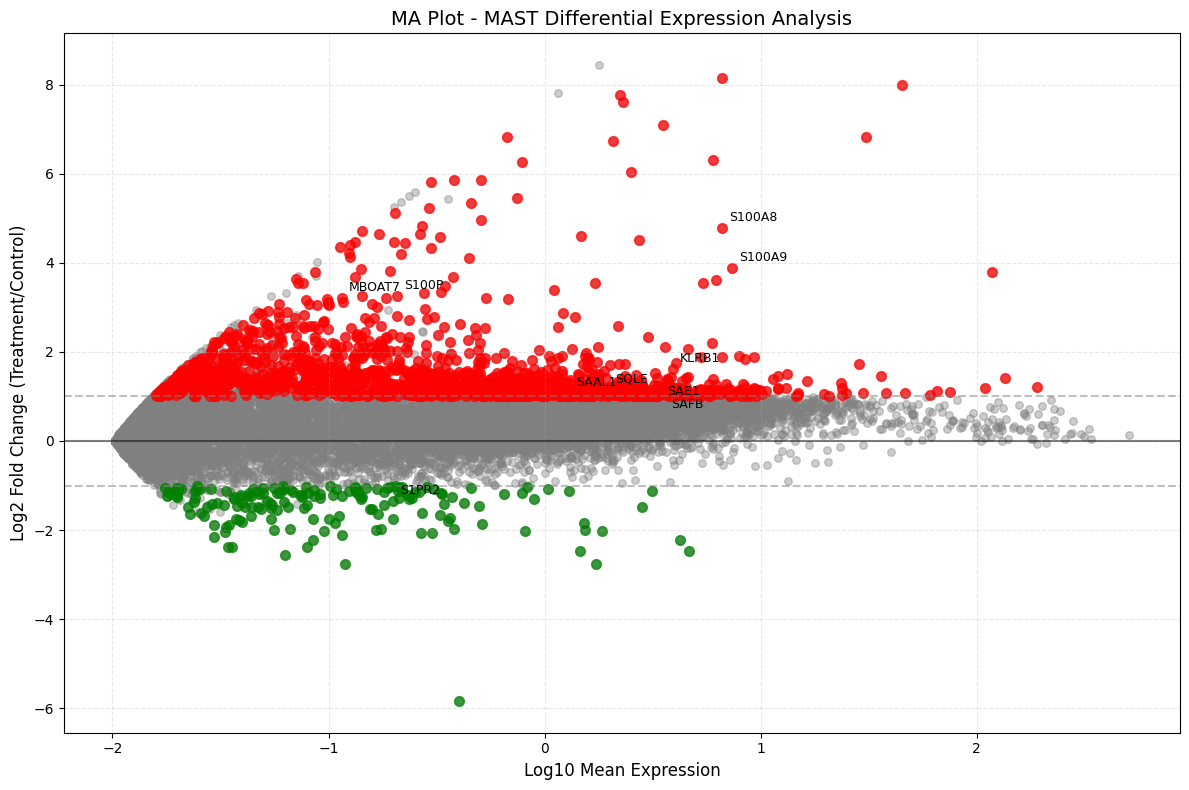

<Figure size 1200x1000 with 0 Axes>

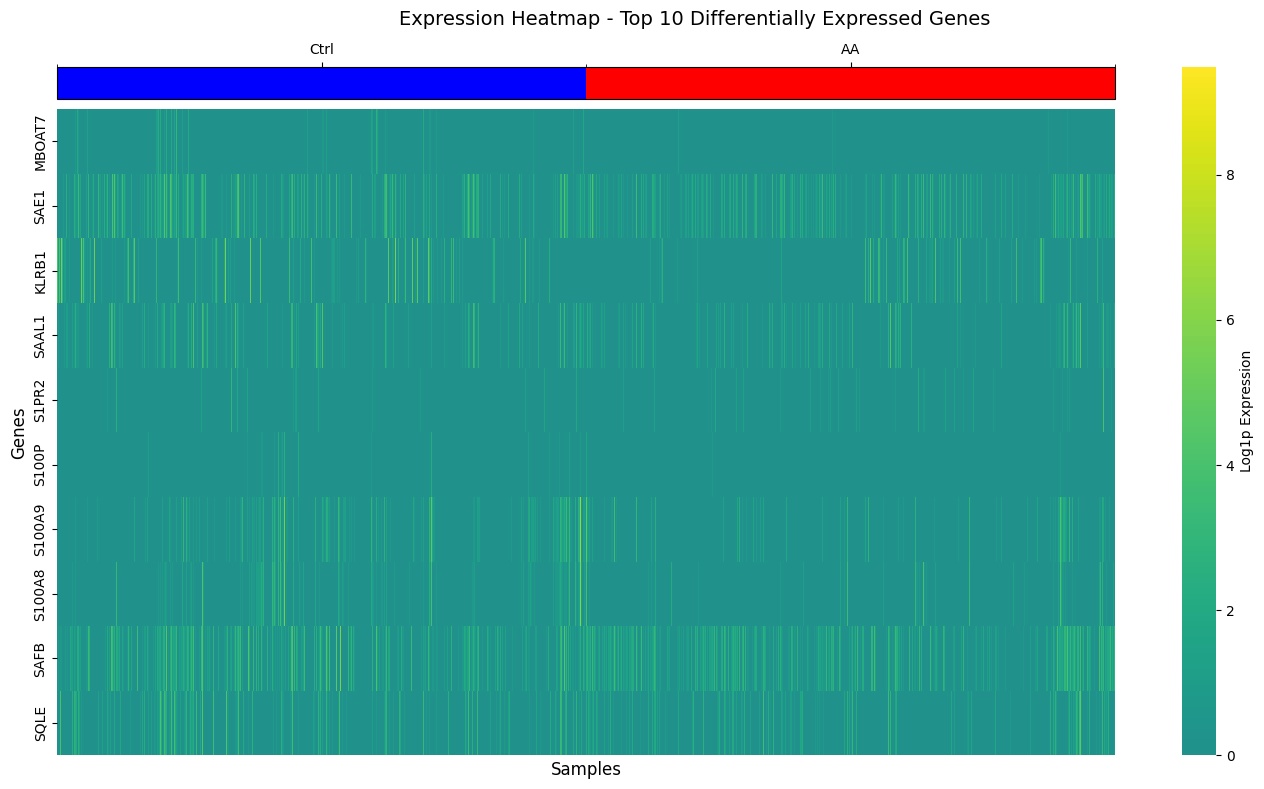

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as multi
from mpl_toolkits.axes_grid1 import make_axes_locatable

def perform_mast_analysis(data, condition_column='Label', control='Ctrl', treatment='AA'):
    """
    Perform MAST (Model-based Analysis of Single-cell Transcriptomics) for differential gene expression
    
    Parameters:
    -----------
    data : DataFrame
        Gene expression data with genes as columns, samples as rows, 
        and a condition column
    condition_column : str
        Column name for condition/group variable
    control : str
        Value in condition column representing control group
    treatment : str
        Value in condition column representing treatment group
    
    Returns:
    --------
    results_df : DataFrame
        Results of differential expression analysis
    """
    # Extract gene columns (exclude the condition column)
    gene_columns = [col for col in data.columns if col != condition_column]
    
    # Initialize results dataframe
    results = []
    
    for gene in gene_columns:
        # Get expression values for each condition
        ctrl_expr = data.loc[data[condition_column] == control, gene]
        treat_expr = data.loc[data[condition_column] == treatment, gene]
        
        # Calculate detection rate (proportion of non-zero values)
        ctrl_detect_rate = (ctrl_expr > 0).mean()
        treat_detect_rate = (treat_expr > 0).mean()
        
        # MAST has two parts:
        # 1. Discrete part (logistic regression on zero vs non-zero) - uses Fisher's exact test here
        detection_table = np.array([
            [(ctrl_expr > 0).sum(), (ctrl_expr == 0).sum()],
            [(treat_expr > 0).sum(), (treat_expr == 0).sum()]
        ])
        
        if np.min(detection_table) >= 0:  # Check for valid counts
            _, p_detect = stats.fisher_exact(detection_table)
        else:
            p_detect = np.nan
        
        # 2. Continuous part (linear model on expression levels in detected cells)
        ctrl_nonzero = ctrl_expr[ctrl_expr > 0]
        treat_nonzero = treat_expr[treat_expr > 0]
        
        # Calculate log fold change and expression statistics
        mean_ctrl = ctrl_expr.mean()
        mean_treat = treat_expr.mean()
        
        # Calculate mean expression across conditions
        mean_expr = (mean_ctrl + mean_treat) / 2
        
        # Calculate fold change
        if mean_ctrl > 0:
            log2fc = np.log2((mean_treat + 0.01) / (mean_ctrl + 0.01))
        else:
            log2fc = np.nan
            
        # T-test on log expression values for expressed cells
        if len(ctrl_nonzero) > 0 and len(treat_nonzero) > 0:
            # Log transform for non-zero values
            log_ctrl = np.log1p(ctrl_nonzero)
            log_treat = np.log1p(treat_nonzero)
            
            # T-test on log expression values
            t_stat, p_cont = stats.ttest_ind(log_treat, log_ctrl, equal_var=False)
        else:
            t_stat = np.nan
            p_cont = np.nan
        
        # Combined p-value using Fisher's method
        if not np.isnan(p_detect) and not np.isnan(p_cont):
            # Fisher's method to combine p-values
            combined_stat = -2 * (np.log(p_detect) + np.log(p_cont))
            combined_p = 1 - stats.chi2.cdf(combined_stat, df=4)
        else:
            combined_p = np.nan
        
        # Calculate additional statistics
        pct_expr_ctrl = (ctrl_expr > 0).mean() * 100
        pct_expr_treat = (treat_expr > 0).mean() * 100
        
        # Store results
        results.append({
            'Gene': gene,
            'mean_ctrl': mean_ctrl,
            'mean_treatment': mean_treat,
            'mean_expression': mean_expr,  # Add mean_expression directly here
            'log2FC': log2fc,
            'pct_expressed_ctrl': pct_expr_ctrl,
            'pct_expressed_treatment': pct_expr_treat,
            'p_detection': p_detect,
            'p_continuous': p_cont,
            'p_combined': combined_p
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Multiple testing correction (FDR - Benjamini-Hochberg)
    _, fdr_values, _, _ = multi.multipletests(
        results_df['p_combined'].fillna(1.0), 
        method='fdr_bh'
    )
    results_df['FDR'] = fdr_values
    
    # Sort by adjusted p-value
    results_df = results_df.sort_values('FDR')
    
    return results_df


def visualize_mast_results(results_df, fdr_threshold=0.05, log2fc_threshold=1.0):
    """
    Create visualization of MAST results
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from perform_mast_analysis
    fdr_threshold : float
        FDR threshold for significance
    log2fc_threshold : float
        Log2 fold change threshold for biological significance
    """
    # Define the top 10 significant genes - we'll use these across all plots
    significant = results_df['FDR'] < fdr_threshold
    top_10_genes = results_df.loc[significant].nsmallest(10, 'FDR')
    
    # 1. Volcano plot
    plt.figure(figsize=(12, 10))
    
    # Basic scatter for all genes
    plt.scatter(
        results_df['log2FC'], 
        -np.log10(results_df['FDR']),
        alpha=0.4, 
        s=30,
        color='grey',
        label='Not significant'
    )
    
    # Highlight significant genes
    up_regulated = (results_df['FDR'] < fdr_threshold) & (results_df['log2FC'] > log2fc_threshold)
    down_regulated = (results_df['FDR'] < fdr_threshold) & (results_df['log2FC'] < -log2fc_threshold)
    
    # Significant but not meeting fold change threshold
    plt.scatter(
        results_df.loc[significant & ~(up_regulated | down_regulated), 'log2FC'],
        -np.log10(results_df.loc[significant & ~(up_regulated | down_regulated), 'FDR']),
        alpha=0.7,
        s=40,
        color='blue',
        label=f'FDR < {fdr_threshold}'
    )
    
    # Up-regulated genes
    plt.scatter(
        results_df.loc[up_regulated, 'log2FC'],
        -np.log10(results_df.loc[up_regulated, 'FDR']),
        alpha=0.7,
        s=50,
        color='red',
        label=f'Up-regulated (FC > {2**log2fc_threshold:.1f})'
    )
    
    # Down-regulated genes
    plt.scatter(
        results_df.loc[down_regulated, 'log2FC'],
        -np.log10(results_df.loc[down_regulated, 'FDR']),
        alpha=0.7,
        s=50,
        color='green',
        label=f'Down-regulated (FC < {1/(2**log2fc_threshold):.1f})'
    )
    
    # Add labels for top 10 genes
    for _, gene in top_10_genes.iterrows():
        fdr_value = gene['FDR'] if gene['FDR'] > 0 else 1e-15
        plt.annotate(
            gene['Gene'], 
            (gene['log2FC'], -np.log10(fdr_value)),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9
        )
    
    # Add lines for significance thresholds
    plt.axhline(-np.log10(fdr_threshold), linestyle='--', color='gray', alpha=0.5)
    plt.axvline(-log2fc_threshold, linestyle='--', color='gray', alpha=0.5)
    plt.axvline(log2fc_threshold, linestyle='--', color='gray', alpha=0.5)
    
    plt.xlabel('Log2 Fold Change (Treatment/Control)', fontsize=12)
    plt.ylabel('-Log10 FDR', fontsize=12)
    plt.title('MAST Differential Expression Analysis', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # 2. MA plot (Mean expression vs Log2 Fold Change)
    plt.figure(figsize=(12, 8))
    
    # Basic scatter for all genes - use mean_expression directly
    plt.scatter(
        np.log10(results_df['mean_expression'] + 0.01),
        results_df['log2FC'],
        alpha=0.4,
        s=30,
        color='grey'
    )
    
    # Highlight significant genes
    plt.scatter(
        np.log10(results_df.loc[up_regulated, 'mean_expression'] + 0.01),
        results_df.loc[up_regulated, 'log2FC'],
        alpha=0.7,
        s=50,
        color='red'
    )
    
    plt.scatter(
        np.log10(results_df.loc[down_regulated, 'mean_expression'] + 0.01),
        results_df.loc[down_regulated, 'log2FC'],
        alpha=0.7,
        s=50,
        color='green'
    )
    
    # Add labels for the same top 10 genes as in volcano plot
    for _, gene in top_10_genes.iterrows():
        plt.annotate(
            gene['Gene'], 
            (np.log10(gene['mean_expression'] + 0.01), gene['log2FC']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9
        )
    
    plt.axhline(0, linestyle='-', color='black', alpha=0.5)
    plt.axhline(log2fc_threshold, linestyle='--', color='gray', alpha=0.5)
    plt.axhline(-log2fc_threshold, linestyle='--', color='gray', alpha=0.5)
    
    plt.xlabel('Log10 Mean Expression', fontsize=12)
    plt.ylabel('Log2 Fold Change (Treatment/Control)', fontsize=12)
    plt.title('MA Plot - MAST Differential Expression Analysis', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # 3. Heatmap of top 10 differentially expressed genes only
    plt.figure(figsize=(12, 10))
    
    # Use just the top 10 genes for the heatmap
    top_de_genes = top_10_genes['Gene'].tolist()
    condition_column = "Label"

    if len(top_de_genes) > 0:
        # Extract expression data for top genes
        top_genes_data = data[top_de_genes + [condition_column]].copy()
        
        # Log transform data for visualization
        for gene in top_de_genes:
            top_genes_data[gene] = np.log1p(top_genes_data[gene])
        
        # Sort samples by condition
        top_genes_data = top_genes_data.sort_values(condition_column)
        
        # Get sample indices for each condition
        ctrl_samples = top_genes_data[top_genes_data[condition_column] == 'Ctrl'].index
        aa_samples = top_genes_data[top_genes_data[condition_column] == 'AA'].index
        
        # Create array of sample labels for coloring the columns
        col_colors = np.array(['blue' if idx in ctrl_samples else 'red' for idx in top_genes_data.index])
        
        # Prepare data for heatmap - keep genes in order of significance
        heatmap_data = top_genes_data[top_de_genes].T
        
        # Set up figure with more space
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Plot heatmap
        sns.heatmap(
            heatmap_data,
            cmap="viridis",
            center=0,
            cbar_kws={'label': 'Log1p Expression'},
            yticklabels=True,
            xticklabels=False,
            ax=ax
        )
        
        # Add color bar on top to indicate conditions
        # Create a separate axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("top", size="5%", pad=0.1)
        
        # Create a colormap with just two colors for the two conditions
        cmap_cond = plt.matplotlib.colors.ListedColormap(['blue', 'red'])
        bounds = [0, 0.5, 1]
        norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap_cond.N)
        
        # Create the colorbar
        cb = plt.colorbar(
            plt.matplotlib.cm.ScalarMappable(cmap=cmap_cond, norm=norm),
            cax=cax, 
            orientation='horizontal',
            ticks=[0.25, 0.75]
        )
        cb.set_ticklabels(['Ctrl', 'AA'])
        cax.xaxis.set_ticks_position('top')
        
        plt.suptitle('Expression Heatmap - Top 10 Differentially Expressed Genes', fontsize=14)
        ax.set_xlabel('Samples', fontsize=12)
        ax.set_ylabel('Genes', fontsize=12)
        
        # Add a legend for the conditions
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', label='Ctrl'),
            Patch(facecolor='red', label='AA')
        ]
        #ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), title="Conditions")
        
        plt.tight_layout()
    
    plt.show()
    
    return

# Main execution code
def run_mast_analysis(data):
    """
    Run the MAST analysis workflow
    
    Parameters:
    -----------
    data : DataFrame
        Gene expression data with genes as columns, samples as rows
    """
    # Perform MAST analysis
    results = perform_mast_analysis(data)
    
    # Print summary statistics
    total_genes = len(results)
    sig_genes = sum(results['FDR'] < 0.05)
    up_genes = sum((results['FDR'] < 0.05) & (results['log2FC'] > 1))
    down_genes = sum((results['FDR'] < 0.05) & (results['log2FC'] < -1))
    
    print(f"Total genes analyzed: {total_genes}")
    print(f"Significantly differentially expressed genes (FDR < 0.05): {sig_genes}")
    print(f"Up-regulated genes (FDR < 0.05, log2FC > 1): {up_genes}")
    print(f"Down-regulated genes (FDR < 0.05, log2FC < -1): {down_genes}")
    
    # Show top up-regulated genes
    print("\nTop up-regulated genes:")
    top_up = results[(results['FDR'] < 0.05) & (results['log2FC'] > 1)].nsmallest(10, 'FDR')
    if not top_up.empty:
        print(top_up[['Gene', 'log2FC', 'FDR', 'pct_expressed_ctrl', 'pct_expressed_treatment']])
    else:
        print("No up-regulated genes found meeting the criteria")
    
    # Show top down-regulated genes
    print("\nTop down-regulated genes:")
    top_down = results[(results['FDR'] < 0.05) & (results['log2FC'] < -1)].nsmallest(10, 'FDR')
    if not top_down.empty:
        print(top_down[['Gene', 'log2FC', 'FDR', 'pct_expressed_ctrl', 'pct_expressed_treatment']])
    else:
        print("No down-regulated genes found meeting the criteria")
    
    # Visualize results
    visualize_mast_results(results)
    
    return results

# Run the analysis
mast_results = run_mast_analysis(data)

In [24]:
mast_results['abs_log2FC'] = np.abs(mast_results['log2FC'])
mast_results.sort_values(by='abs_log2FC', ascending=False)
mast_results.to_csv('MAST_DE_genes.csv')

# Statistical Approach

In [8]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

ctrl_samples = data[data['Label'] == 'Ctrl']

AA_samples = data[data['Label'] == 'AA'] 


results = []
gene_symbols = data.columns[:-1]

for gene in gene_symbols:
    ctrl_expr = ctrl_samples[gene].values
    AA_expr = AA_samples[gene].values
    
    if np.sum(ctrl_expr) == 0 and np.sum(AA_expr) == 0:
        continue
    
    mean_ctrl = np.mean(ctrl_expr)
    mean_other = np.mean(AA_expr)
    
    epsilon = 1e-10
    fold_change = np.log2((mean_other + epsilon) / (mean_ctrl + epsilon))
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(AA_expr, ctrl_expr, equal_var=False)
    
    # Store results
    results.append({
        'Gene': gene,
        'Mean_Ctrl': mean_ctrl,
        'Mean_AA': mean_other,
        'Log2FC': fold_change,
        'P_value': p_value
    })

# Convert results to DataFrame
result_df = pd.DataFrame(results)

In [9]:
from statsmodels.stats.multitest import multipletests
result_df['Adj_P_value'] = multipletests(result_df['P_value'], method='fdr_bh')[1]

result_df = result_df.sort_values('Adj_P_value')
result_df.to_csv('differential_expression_results.csv', index=False)

# Get top differentially expressed genes
top_genes = result_df.head(50)
print("Top differentially expressed genes:")
print(top_genes)

Top differentially expressed genes:
            Gene   Mean_Ctrl     Mean_AA    Log2FC       P_value   Adj_P_value
6590       HLA-C    7.910714    1.410313 -2.487793  5.327365e-95  9.206752e-91
12552      RPS26   13.253843   43.925077  1.728634  2.284015e-72  1.973617e-68
3042        CISH    3.021248    0.433671 -2.800471  1.007033e-54  5.801181e-51
6599    HLA-DRB5    0.013336    4.577788  8.423143  3.411532e-51  1.473952e-47
12560      RPS4X  114.502260  265.961437  1.215841  9.830830e-51  3.397928e-47
9126    MTRNR2L1    0.021474    0.972014  5.500329  1.208644e-50  3.481298e-47
8943      MRPL23    0.325497    1.964742  2.593623  2.751932e-50  6.794126e-47
6598    HLA-DRB1    1.852396    6.269502  1.758958  5.652855e-49  1.221158e-45
13380    SLC25A5   15.982143   33.568092  1.070630  7.486023e-49  1.437483e-45
6323       H2AFZ   19.236212   52.998457  1.462126  2.958415e-48  5.112733e-45
1419         B2M   73.919078  196.220802  1.408459  4.217837e-48  6.626606e-45
4527      EIF1AX

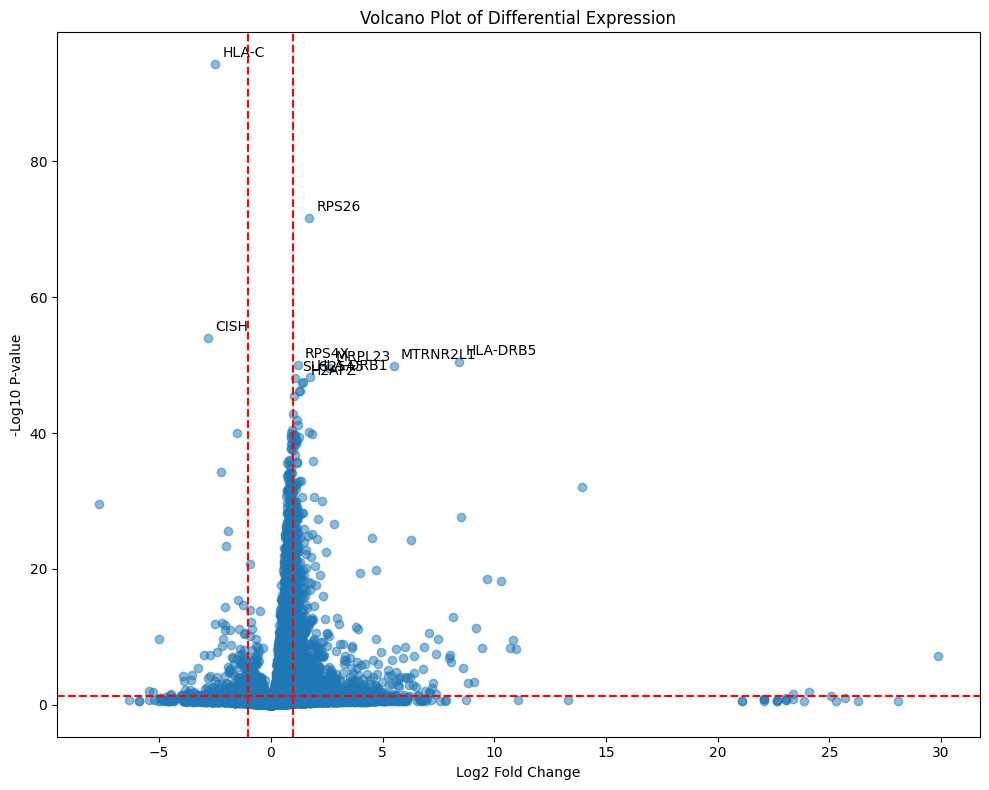

In [10]:
# Volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(result_df['Log2FC'], -np.log10(result_df['P_value']), alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--')
plt.axvline(x=-1, color='r', linestyle='--')
plt.axvline(x=1, color='r', linestyle='--')
# Label top genes
for idx, row in top_genes.head(10).iterrows():
    plt.annotate(row['Gene'], 
                 xy=(row['Log2FC'], -np.log10(row['P_value'])),
                 xytext=(5, 5), textcoords='offset points')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 P-value')
plt.title('Volcano Plot of Differential Expression')
plt.tight_layout()
plt.savefig('volcano_plot.png')
plt.show()


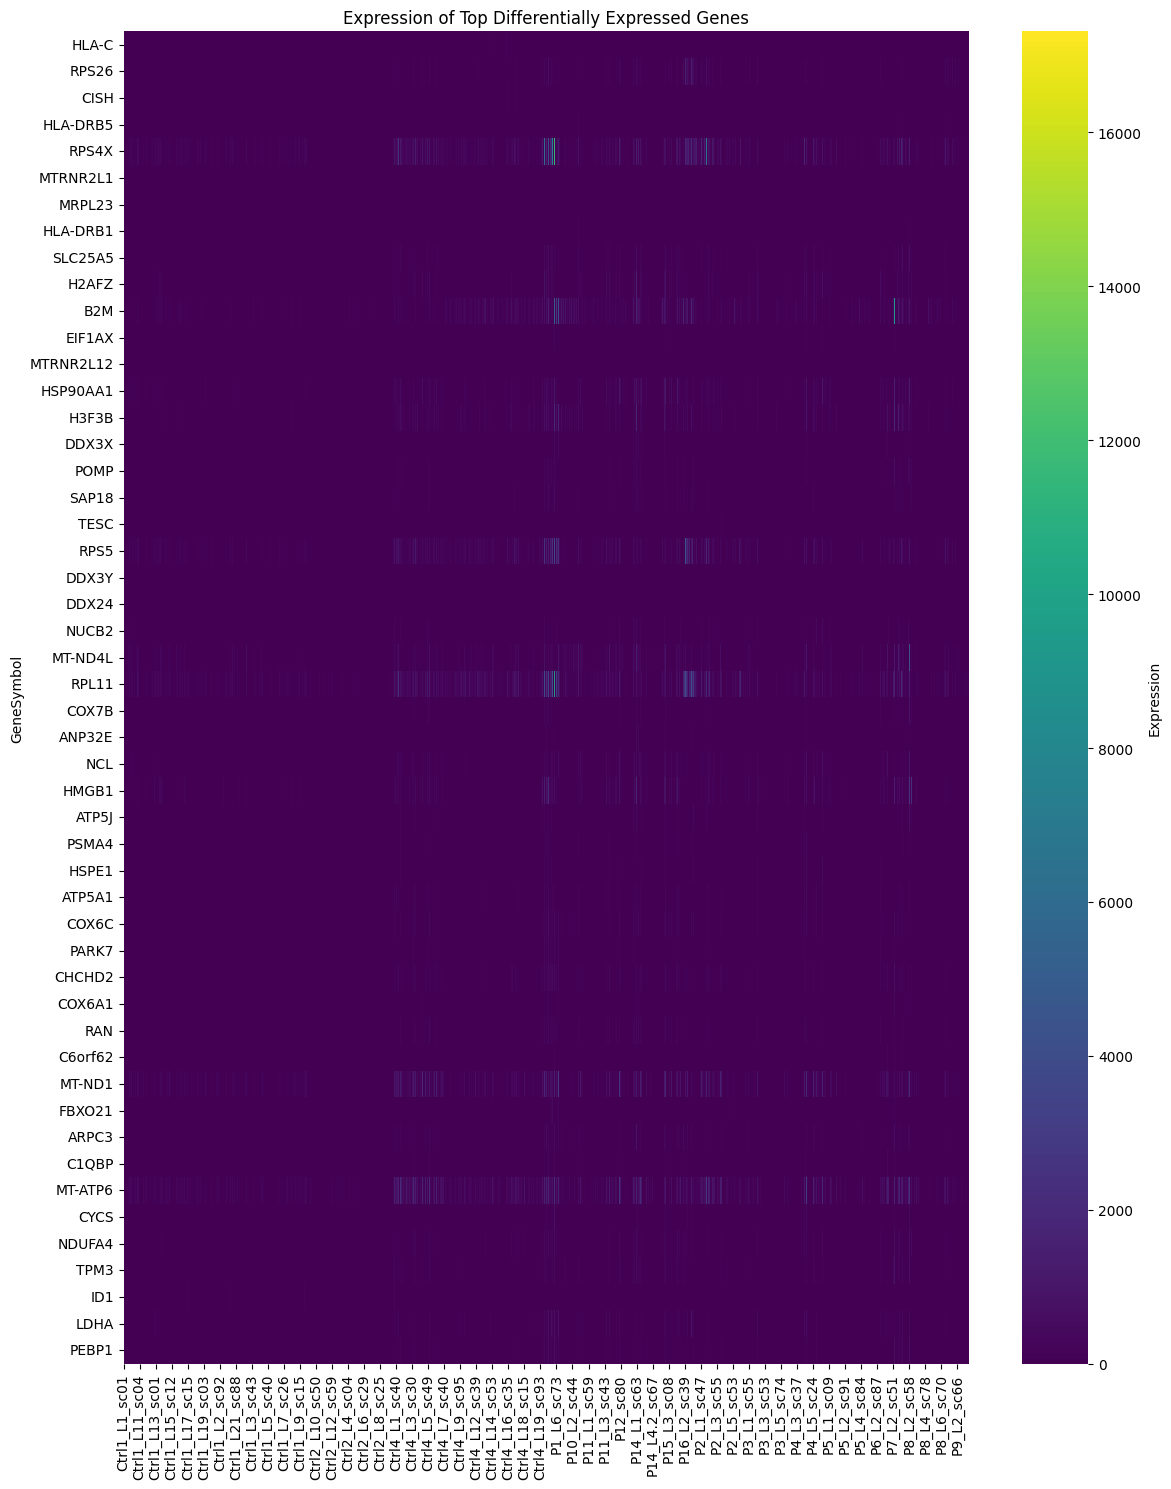

In [11]:
# Heatmap of top genes
top_gene_list = top_genes['Gene'].tolist()
top_genes.to_csv('top_differentially_expressed_genes.csv', index=False)
plt.figure(figsize=(12, len(top_gene_list) * 0.3))
sns.heatmap(data[top_gene_list].transpose(), cmap="viridis", 
            yticklabels=top_gene_list, 
            cbar_kws={'label': 'Expression'})
plt.title('Expression of Top Differentially Expressed Genes')
plt.tight_layout()
plt.savefig('heatmap_top_genes.png')
plt.show()